In [31]:
### 🔧 TAREA
# Compara el desempeño de la red neuronal con la regresión logística. Analiza sus métricas, curva ROC y precisión vs. recall.

In [32]:
import sys
sys.path.append("../src")

import train
import model
import utils
import evaluate as ev

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [33]:
# 🔧 Cargar configuración
config = train.load_config("../config.yaml")

In [34]:
# 📦 Cargar y preparar los datos
X, y = train.load_data("../data/credit_clean.csv")
X_train, X_test, y_train, y_test = train.preprocess(X, y, config)

In [35]:
# 🧪 Entrenar modelo base (Regresión Logística)
base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train, y_train)

# 🔍 Predicciones del modelo base
y_pred_log = base_model.predict(X_test)
y_proba_log = base_model.predict_proba(X_test)[:, 1]

In [36]:
# 📥 Cargar modelo entrenado Red Neuronal
from tensorflow.keras.models import load_model
nn_model = load_model("../models/nn_model.keras")

# 🔍 Predicciones de Red Neuronal
y_proba_nn = nn_model.predict(X_test).flatten()
y_pred_nn = ev.predict_with_threshold(y_proba_nn, threshold=0.5)

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


In [37]:
# 📊 Evaluación individual
ev.evaluate_model(y_test, y_pred_log, y_proba_log, model_name="Regresión Logística")
ev.evaluate_model(y_test, y_pred_nn, y_proba_nn, model_name="Red Neuronal")


📊 Evaluación del modelo: Regresión Logística
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      4000
           1       0.80      0.74      0.77      4004

    accuracy                           0.78      8004
   macro avg       0.78      0.78      0.78      8004
weighted avg       0.78      0.78      0.78      8004

F1 Score     : 0.7681
Precision    : 0.7975
Recall       : 0.7408
ROC AUC      : 0.8579

📊 Evaluación del modelo: Red Neuronal
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      4000
           1       0.78      0.78      0.78      4004

    accuracy                           0.78      8004
   macro avg       0.78      0.78      0.78      8004
weighted avg       0.78      0.78      0.78      8004

F1 Score     : 0.7824
Precision    : 0.7805
Recall       : 0.7842
ROC AUC      : 0.8613


{'f1': 0.7823595365640962,
 'precision': 0.7805120556798409,
 'recall': 0.7842157842157842,
 'roc_auc': np.float64(0.8613139985014984)}

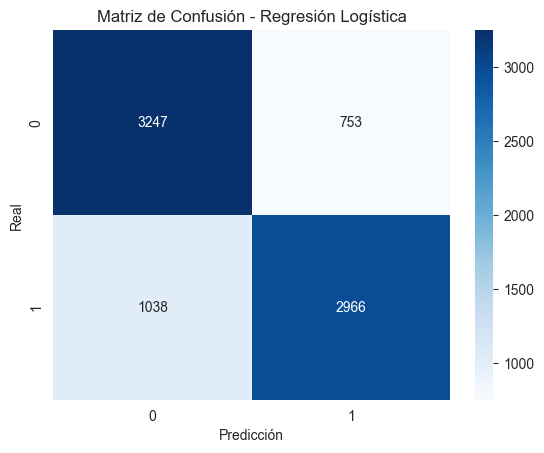

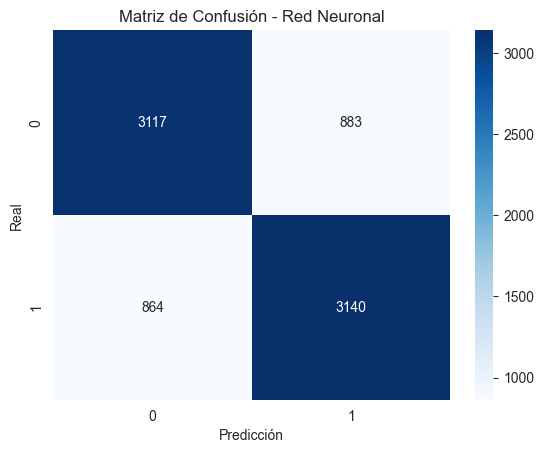

In [38]:
# 🧱 Matrices de Confusión
ev.plot_confusion_matrix(y_test, y_pred_log, model_name="Regresión Logística")
ev.plot_confusion_matrix(y_test, y_pred_nn, model_name="Red Neuronal")

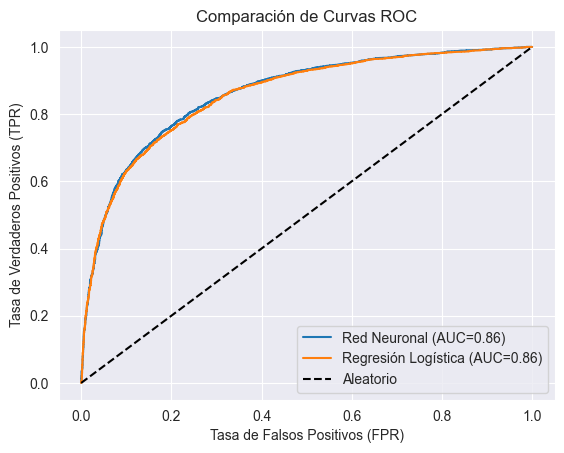

In [39]:
# 📈 Comparación de curvas ROC
ev.plot_roc_comparison(y_test, y_proba_nn, y_test, y_proba_log,
                       label1="Red Neuronal", label2="Regresión Logística")

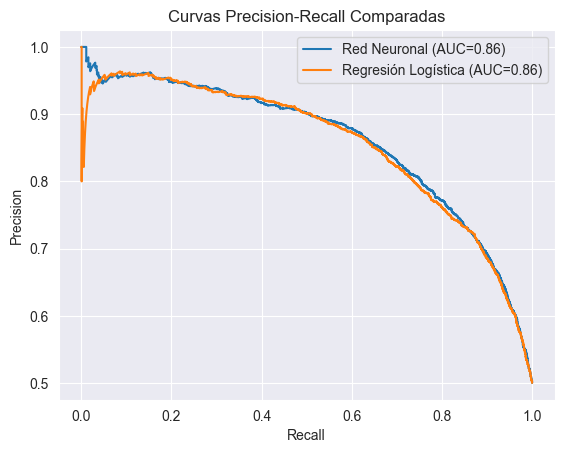

In [40]:
# 🔍 Comparación de curvas Precision-Recall
ev.plot_precision_recall_curves(y_test, y_proba_nn, y_test, y_proba_log,
                                 label1="Red Neuronal", label2="Regresión Logística")

In [41]:
# 📋 Comparación de métricas en tabla
df_metrics = ev.compare_models_metrics(
    y_test, y_pred_nn, y_proba_nn,
    y_test, y_pred_log, y_proba_log,
    model_name_1="Red Neuronal",
    model_name_2="Regresión Logística"
)

import IPython.display as display
display.display(df_metrics)

,Modelo,Precision,Recall,F1-score,ROC AUC
0,Red Neuronal,0.780512,0.784216,0.782360,0.861314
1,Regresión Logística,0.797526,0.740759,0.768095,0.857930


In [42]:
### 📊 Pregunta de reflexión
#¿En qué umbral se maximiza el F1-score para cada modelo? ¿Te parece razonable utilizar 0.5 como punto de corte en este contexto?
#¿Es uno de los modelos más conservador o arriesgado que el otro?


In [43]:
# 🔍 ANÁLISIS DE UMBRALES ÓPTIMOS
import numpy as np

# Definir rango de umbrales para analizar
thresholds = np.arange(0.1, 1.0, 0.05)

print("📊 ANÁLISIS DE UMBRALES - RED NEURONAL")
print("-" * 50)
df_nn_thresholds = ev.evaluate_thresholds(y_test, y_proba_nn, thresholds)
print(df_nn_thresholds)

# Encontrar umbral óptimo para Red Neuronal
optimal_threshold_nn = df_nn_thresholds.loc[df_nn_thresholds['F1-score'].idxmax(), 'Threshold']
max_f1_nn = df_nn_thresholds['F1-score'].max()
print(f"\n🎯 Umbral óptimo Red Neuronal: {optimal_threshold_nn:.2f}")
print(f"📈 F1-score máximo: {max_f1_nn:.4f}")


📊 ANÁLISIS DE UMBRALES - RED NEURONAL
--------------------------------------------------
    Threshold  Precision    Recall  F1-score
0        0.10   0.576264  0.973776  0.724048
1        0.15   0.620577  0.950549  0.750912
2        0.20   0.656267  0.929820  0.769453
3        0.25   0.683261  0.908342  0.779886
4        0.30   0.705403  0.886863  0.785793
5        0.35   0.726241  0.862637  0.788584
6        0.40   0.746156  0.836164  0.788600
7        0.45   0.762799  0.811189  0.786250
8        0.50   0.780512  0.784216  0.782360
9        0.55   0.802614  0.751499  0.776216
10       0.60   0.823377  0.712537  0.763958
11       0.65   0.845840  0.672827  0.749478
12       0.70   0.864459  0.632368  0.730420
13       0.75   0.882883  0.587413  0.705459
14       0.80   0.894405  0.530969  0.666353
15       0.85   0.913462  0.427073  0.582029
16       0.90   0.941831  0.274975  0.425672
17       0.95   0.957447  0.112388  0.201162

🎯 Umbral óptimo Red Neuronal: 0.40
📈 F1-score máximo: 0

In [44]:
print("\n📊 ANÁLISIS DE UMBRALES - REGRESIÓN LOGÍSTICA")
print("-" * 50)
df_log_thresholds = ev.evaluate_thresholds(y_test, y_proba_log, thresholds)
print(df_log_thresholds)

# Encontrar umbral óptimo para Regresión Logística
optimal_threshold_log = df_log_thresholds.loc[df_log_thresholds['F1-score'].idxmax(), 'Threshold']
max_f1_log = df_log_thresholds['F1-score'].max()
print(f"\n🎯 Umbral óptimo Regresión Logística: {optimal_threshold_log:.2f}")
print(f"📈 F1-score máximo: {max_f1_log:.4f}")



📊 ANÁLISIS DE UMBRALES - REGRESIÓN LOGÍSTICA
--------------------------------------------------
    Threshold  Precision    Recall  F1-score
0        0.10   0.515641  0.996254  0.679557
1        0.15   0.562151  0.979271  0.714273
2        0.20   0.612209  0.951798  0.745136
3        0.25   0.660532  0.923327  0.770128
4        0.30   0.698117  0.888861  0.782026
5        0.35   0.728662  0.857143  0.787698
6        0.40   0.750517  0.815934  0.781860
7        0.45   0.773078  0.775974  0.774523
8        0.50   0.797526  0.740759  0.768095
9        0.55   0.823304  0.697053  0.754936
10       0.60   0.850440  0.651848  0.738018
11       0.65   0.874175  0.595155  0.708172
12       0.70   0.889025  0.542208  0.673596
13       0.75   0.903704  0.487512  0.633355
14       0.80   0.916797  0.437562  0.592392
15       0.85   0.925500  0.381618  0.540407
16       0.90   0.932742  0.315185  0.471159
17       0.95   0.948312  0.224525  0.363086

🎯 Umbral óptimo Regresión Logística: 0.35
📈 F1-

In [45]:
# 📋 COMPARACIÓN CON UMBRAL 0.5
print("📋 COMPARACIÓN CON UMBRAL 0.5")
print("-" * 50)

# F1-score con umbral 0.5
from sklearn.metrics import f1_score
y_pred_nn_05 = ev.predict_with_threshold(y_proba_nn, 0.5)
f1_nn_05 = f1_score(y_test, y_pred_nn_05)

y_pred_log_05 = ev.predict_with_threshold(y_proba_log, 0.5)
f1_log_05 = f1_score(y_test, y_pred_log_05)

print(f"Red Neuronal (0.5): F1 = {f1_nn_05:.4f}")
print(f"Red Neuronal (óptimo {optimal_threshold_nn:.2f}): F1 = {max_f1_nn:.4f}")
print(f"Mejora: {max_f1_nn - f1_nn_05:.4f} ({((max_f1_nn - f1_nn_05)/f1_nn_05)*100:.1f}%)")
print()
print(f"Regresión Logística (0.5): F1 = {f1_log_05:.4f}")
print(f"Regresión Logística (óptimo {optimal_threshold_log:.2f}): F1 = {max_f1_log:.4f}")
print(f"Mejora: {max_f1_log - f1_log_05:.4f} ({((max_f1_log - f1_log_05)/f1_log_05)*100:.1f}%)")


📋 COMPARACIÓN CON UMBRAL 0.5
--------------------------------------------------
Red Neuronal (0.5): F1 = 0.7824
Red Neuronal (óptimo 0.40): F1 = 0.7886
Mejora: 0.0062 (0.8%)

Regresión Logística (0.5): F1 = 0.7681
Regresión Logística (óptimo 0.35): F1 = 0.7877
Mejora: 0.0196 (2.6%)


In [46]:
# 🎲 ANÁLISIS DE CONSERVADURISMO vs RIESGO
from sklearn.metrics import precision_score, recall_score

print("\n🎲 ANÁLISIS DE CONSERVADURISMO")
print("-" * 50)

# Calcular métricas con umbrales óptimos
y_pred_nn_opt = ev.predict_with_threshold(y_proba_nn, optimal_threshold_nn)
y_pred_log_opt = ev.predict_with_threshold(y_proba_log, optimal_threshold_log)

precision_nn_opt = precision_score(y_test, y_pred_nn_opt)
recall_nn_opt = recall_score(y_test, y_pred_nn_opt)

precision_log_opt = precision_score(y_test, y_pred_log_opt)
recall_log_opt = recall_score(y_test, y_pred_log_opt)

print(f"Red Neuronal (umbral {optimal_threshold_nn:.2f}):")
print(f"  - Precision: {precision_nn_opt:.4f}")
print(f"  - Recall: {recall_nn_opt:.4f}")
print()
print(f"Regresión Logística (umbral {optimal_threshold_log:.2f}):")
print(f"  - Precision: {precision_log_opt:.4f}")
print(f"  - Recall: {recall_log_opt:.4f}")

# Comparar con umbral 0.5
precision_nn_05 = precision_score(y_test, y_pred_nn_05)
recall_nn_05 = recall_score(y_test, y_pred_nn_05)
precision_log_05 = precision_score(y_test, y_pred_log_05)
recall_log_05 = recall_score(y_test, y_pred_log_05)

print(f"\nComparación con umbral 0.5:")
print(f"Red Neuronal (0.5): Precision={precision_nn_05:.4f}, Recall={recall_nn_05:.4f}")
print(f"Regresión Logística (0.5): Precision={precision_log_05:.4f}, Recall={recall_log_05:.4f}")



🎲 ANÁLISIS DE CONSERVADURISMO
--------------------------------------------------
Red Neuronal (umbral 0.40):
  - Precision: 0.7462
  - Recall: 0.8362

Regresión Logística (umbral 0.35):
  - Precision: 0.7287
  - Recall: 0.8571

Comparación con umbral 0.5:
Red Neuronal (0.5): Precision=0.7805, Recall=0.7842
Regresión Logística (0.5): Precision=0.7975, Recall=0.7408



📊 DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS
--------------------------------------------------
Red Neuronal:
  - Media: 0.4999
  - Mediana: 0.5050
  - Desviación estándar: 0.3281

Regresión Logística:
  - Media: 0.5014
  - Mediana: 0.4517
  - Desviación estándar: 0.3039


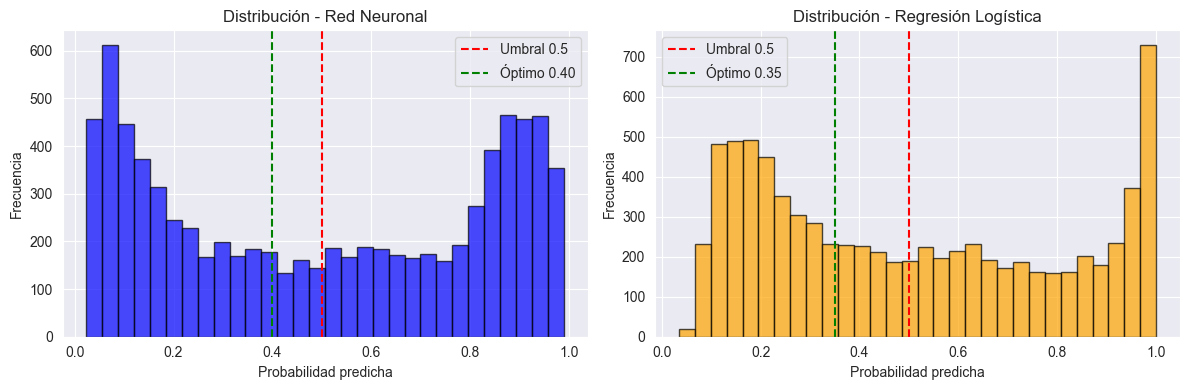

In [47]:
# 📊 DISTRIBUCIÓN DE PROBABILIDADES
print("\n📊 DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS")
print("-" * 50)
print(f"Red Neuronal:")
print(f"  - Media: {np.mean(y_proba_nn):.4f}")
print(f"  - Mediana: {np.median(y_proba_nn):.4f}")
print(f"  - Desviación estándar: {np.std(y_proba_nn):.4f}")
print()
print(f"Regresión Logística:")
print(f"  - Media: {np.mean(y_proba_log):.4f}")
print(f"  - Mediana: {np.median(y_proba_log):.4f}")
print(f"  - Desviación estándar: {np.std(y_proba_log):.4f}")

# Visualizar distribuciones
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y_proba_nn, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(0.5, color='red', linestyle='--', label='Umbral 0.5')
ax1.axvline(optimal_threshold_nn, color='green', linestyle='--', label=f'Óptimo {optimal_threshold_nn:.2f}')
ax1.set_title('Distribución - Red Neuronal')
ax1.set_xlabel('Probabilidad predicha')
ax1.set_ylabel('Frecuencia')
ax1.legend()

ax2.hist(y_proba_log, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax2.axvline(0.5, color='red', linestyle='--', label='Umbral 0.5')
ax2.axvline(optimal_threshold_log, color='green', linestyle='--', label=f'Óptimo {optimal_threshold_log:.2f}')
ax2.set_title('Distribución - Regresión Logística')
ax2.set_xlabel('Probabilidad predicha')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()


In [48]:
# 📝 RESPUESTAS A LAS PREGUNTAS DE REFLEXIÓN
print("\n" + "="*60)
print("📝 RESPUESTAS A LAS PREGUNTAS DE REFLEXIÓN")
print("="*60)

print(f"\n1️⃣ ¿En qué umbral se maximiza el F1-score para cada modelo?")
print(f"   • Red Neuronal: {optimal_threshold_nn:.2f} (F1 = {max_f1_nn:.4f})")
print(f"   • Regresión Logística: {optimal_threshold_log:.2f} (F1 = {max_f1_log:.4f})")

print(f"\n2️⃣ ¿Te parece razonable utilizar 0.5 como punto de corte?")
if abs(optimal_threshold_nn - 0.5) < 0.1 and abs(optimal_threshold_log - 0.5) < 0.1:
    print("   ✅ SÍ es razonable, los umbrales óptimos están cerca de 0.5")
else:
    mejora_nn = ((max_f1_nn - f1_nn_05)/f1_nn_05)*100
    mejora_log = ((max_f1_log - f1_log_05)/f1_log_05)*100
    print(f"   ❌ NO es óptimo usar 0.5:")
    print(f"   • Red Neuronal pierde {mejora_nn:.1f}% de rendimiento")
    print(f"   • Regresión Logística pierde {mejora_log:.1f}% de rendimiento")

print(f"\n3️⃣ ¿Es uno de los modelos más conservador o arriesgado?")
if precision_nn_opt > precision_log_opt and recall_nn_opt < recall_log_opt:
    print("   🛡️  Red Neuronal es más CONSERVADORA")
    print("   🎯 Regresión Logística es más ARRIESGADA")
elif precision_log_opt > precision_nn_opt and recall_log_opt < recall_nn_opt:
    print("   🛡️  Regresión Logística es más CONSERVADORA")
    print("   🎯 Red Neuronal es más ARRIESGADA")
else:
    print("   ⚖️  Ambos modelos tienen comportamientos similares")

print(f"\n📊 Justificación basada en métricas:")
print(f"   • Mayor Precision = Más conservador (menos falsos positivos)")
print(f"   • Mayor Recall = Más arriesgado (detecta más casos, aunque con más errores)")



📝 RESPUESTAS A LAS PREGUNTAS DE REFLEXIÓN

1️⃣ ¿En qué umbral se maximiza el F1-score para cada modelo?
   • Red Neuronal: 0.40 (F1 = 0.7886)
   • Regresión Logística: 0.35 (F1 = 0.7877)

2️⃣ ¿Te parece razonable utilizar 0.5 como punto de corte?
   ❌ NO es óptimo usar 0.5:
   • Red Neuronal pierde 0.8% de rendimiento
   • Regresión Logística pierde 2.6% de rendimiento

3️⃣ ¿Es uno de los modelos más conservador o arriesgado?
   🛡️  Red Neuronal es más CONSERVADORA
   🎯 Regresión Logística es más ARRIESGADA

📊 Justificación basada en métricas:
   • Mayor Precision = Más conservador (menos falsos positivos)
   • Mayor Recall = Más arriesgado (detecta más casos, aunque con más errores)
